In [1]:
import simpy
import numpy as np
import functools
import matplotlib.pyplot as plt
from simpy_helpers import Entity, Resource, Source, Stats

## Description of problem: 

We are going to model a restaurant.

Customers can be either take out or dine in customers

Take out customers will have higher priority, since they are in a hurry.

Customers start by ordering, which is passed to the kitchen.
The Kitchen is described as follows: 
 - 2 cooks
 - 3 things to order:
   - fish -- 15 mins to prepare
   - burger -- 5 mins to prepare
   - salad -- 8 mins to prepare
   
Then must wait for a seat
- people will sit for between 20-30 minutes. 
- Capacity: 4
- Assume all attendees are dining alone (no need to worry about specific party capacity, or matching to tables).


In [2]:
# Our Kitchen class subclasses PriorityResource. We give it a unique name of "kitchen"
class Kitchen(Resource):
    def service_time(self, entity):
        """
        Defines preparation time for each dish
        Since we can pass the entity being processed to service_time when we call it, 
        we can react to the requirements of the entity (e.g. fish takes longer to prepare)
        """
        if entity.attributes["food"] == "Fish":
            return 100
        elif entity.attributes["food"] == "Burger":
            return 5
        elif entity.attributes["food"] == "Salad":
            return 8
        else:
            raise Exception("Restaurant does not serve this kind of food")
        

# Our DiningRoom class subclasses Resource. We give it a unique name of "DiningRoom"
class DiningRoom(Resource):
    def service_time(self):
        """
        random integer of time between 20 and 30 minutes per problem specification
        """
        return np.random.randint(20, 30) # 20 to 30 minute seating per entity



In [3]:
# entities are in charge of the order in which interactions with resources occur
class DineInCustomer(Entity):
    
    priority = 1
    
    # template method for all of the resources it needs to interact with
    def process(self):
        
        # interface with kitchen
        yield self.wait_for_resource(kitchen)
        yield self.process_at_resource(kitchen)
        self.release_resource(kitchen)
        
        # interface with dining_room
        yield self.wait_for_resource(dining_room)
        yield self.process_at_resource(dining_room)
        self.release_resource(dining_room)

class TakeOutCustomer(Entity):
    
    priority = 0
    
    # template method for all of the resources it needs to interact with
    def process(self):
        # interface with kitchen
        yield self.wait_for_resource(kitchen)
        yield self.process_at_resource(kitchen) 
        self.release_resource(kitchen)
        # take out does not need to go to the dining room
        

In [4]:
# The source is what contains the interarrival time definition, and rules for constructing entities 
# with various attribute sets.
class CustomerSource(Source):
    def interarrival_time(self):
        return np.random.choice([1,10,15,20], p=[0.5, 0.2, 0.2, 0.1])
    
    def sample_from_foods(self):
        return np.random.choice(["Fish", "Burger", "Salad"], p=[0.1,0.7,0.2])
    
    def is_dine_in(self):
        # returns true if the customer is dine in with a 50% likelihood
        return np.random.random() > 0.50
    
    def build_entity(self):
        attributes = {
            "food": self.sample_from_foods()
        }
        if self.is_dine_in():
            return DineInCustomer(env, attributes)
         
        return TakeOutCustomer(env, attributes)

In [5]:
np.random.seed(42)
# Create simulation environment
env = simpy.Environment()

# Configure source to generate fixed number of entities
source = CustomerSource(env, number=10)

# Configure DiningRoom to have space for 4 diners
dining_room = DiningRoom(env,  capacity=4)

# Configure Kitchen to have 2 chefs
kitchen = Kitchen(env, capacity=2)

# Aside: if students want to tune various parameters of the simulation, they could configure each component
#        of the simulation here, then loop over the construction of each with different combinations of parameters

In [6]:
env.process(source.start())
env.run()

In [7]:
# extract summary statistics from the Stats class
system_time = Stats.get_total_times()
print("total_time:", Stats.get_total_times())
print("waiting_time:", Stats.get_waiting_times())
print("processing_time:", Stats.get_processing_times())

print("waiting time at kitchen", Stats.get_waiting_times(kitchen))
print("processing time at kitchen", Stats.get_processing_times(kitchen))

print("waiting time at dining_room", Stats.get_waiting_times(dining_room))
print("processing time at dining_room", Stats.get_processing_times(dining_room))

# It's also possible to filter by entity types or attributes.
print("total waiting_time for entities that ate fish:", Stats.get_waiting_times(attributes={"food": "Fish"}))
print("processing time at dining_room for entities that ate burgers", Stats.get_processing_times(resource=dining_room, attributes={"food": "Burger"}))
print("total time for entities that ate salad", Stats.get_total_times(attributes={"food": "Salad"}))

# you can additionally filter by the type of the entity
print("total processing_time at kitchen for entities that were TakeOutCustomers that ate burgers", Stats.get_processing_times(resource=kitchen, attributes={"food": "Burger", "type": TakeOutCustomer}))
print("total processing_time at dining_room for entities that were DineInCustomers that ate burgers", Stats.get_processing_times(resource=dining_room, attributes={"food": "Burger", "type": DineInCustomer}))

total_time: [35, 5, 34, 30, 32, 100, 8, 5, 34, 134]
waiting_time: [0, 0, 0, 3, 3, 0, 0, 0, 0, 7]
processing_time: [35, 5, 34, 27, 29, 100, 8, 5, 34, 127]
waiting time at kitchen [0, 0, 0, 3, 3, 0, 0, 0, 0, 7]
processing time at kitchen [8, 5, 5, 5, 8, 100, 8, 5, 8, 100]
waiting time at dining_room [0, None, 0, 0, 0, None, None, None, 0, 0]
processing time at dining_room [27, None, 29, 22, 21, None, None, None, 26, 27]
total waiting_time for entities that ate fish: [0, 7]
processing time at dining_room for entities that ate burgers [None, 29, 22, None]
total time for entities that ate salad [35, 32, 8, 34]
total processing_time at kitchen for entities that were TakeOutCustomers that ate burgers [5, 5]
total processing_time at dining_room for entities that were DineInCustomers that ate burgers [29, 22]


In [12]:
# testing that the get_entities function works

entities = Stats.get_entities()
print("total_time:", [entity.get_total_time() for entity in entities])
print("waiting_time:", [entity.get_total_waiting_time() for entity in entities])
print("total_time:", [entity.get_total_time() for entity in entities])

print("waiting time at kitchen", [entity.get_waiting_time_for_resource(kitchen) for entity in entities])
print("waiting time at dining_room", [entity.get_waiting_time_for_resource(dining_room) for entity in entities])


total_time: [35, 5, 34, 30, 32, 100, 8, 5, 34, 134]
waiting_time: [0, 0, 0, 3, 3, 0, 0, 0, 0, 7]
total_time: [35, 5, 34, 30, 32, 100, 8, 5, 34, 134]
waiting time at kitchen [0, 0, 0, 3, 3, 0, 0, 0, 0, 7]
waiting time at dining_room [0, None, 0, 0, 0, None, None, None, 0, 0]


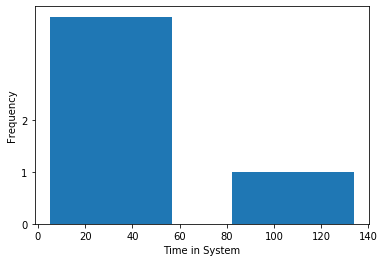

In [37]:
plt.hist(system_time,bins=5)
# you can customize the exact tick marks on an axis
plt.yticks(range(0,3))
plt.ylabel('Frequency');
plt.xlabel('Time in System');

Average number in queue: 0.06666666666666667
Max in queue: 2


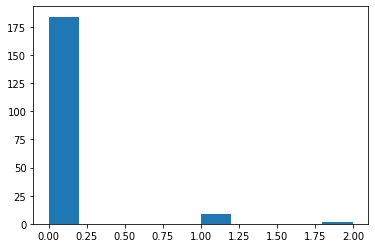

In [38]:
"""
Histogram of queue over time
"""
plt.hist(queue_over_time_kitchen)
print(f"Average number in queue: {np.mean(queue_over_time_kitchen)}")
print(f"Max in queue: {np.max(queue_over_time_kitchen)}")

Average number in queue: 0.0
Max in queue: 0


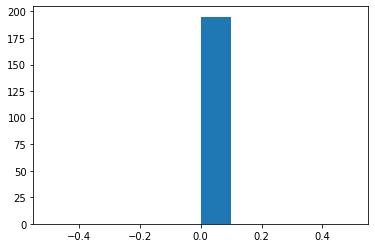

In [39]:
plt.hist(queue_over_time_dining_room)
print(f"Average number in queue: {np.mean(queue_over_time_dining_room)}")
print(f"Max in queue: {np.max(queue_over_time_dining_room)}")

In [40]:
print(f"max system time {np.max(system_time)}")
# 50th percentile, or median
print(f"50th percentile time {np.percentile(system_time,50)}")
print(f"std system time {np.std(system_time)}")

max system time 134
50th percentile time 33.0
std system time 40.17723235863814


## What next? 

Adjust capacities at each resource and see how the summary statistics change.
- how many chefs do you need in the kitchen to ensure 0 wait times with the current interarrival function? 
- What if we expanded our dining room... How big would we need to make the average wait time for a seat to be under 10 minutes? 

Could also adjust interarrival times / resource service times to see how that impacts
- What if we retrained chefs to cook fish 5 seconds faster... would that impact wait times? 
- What if we get a huge rush at night and interarrival time spikes to 1 minute. How bad would wait times get? 
- How to implement reneging customers? 